In [1]:
import re
import random
import pandas as pd
import matplotlib.pyplot as plt

### Simple data cleaning

In [2]:
FULL_DATA = 'data/training.1600000.processed.noemoticon.csv'
cols = ['sentiment', 'id', 'date', 'query_string', 'user', 'text']
df_full = pd.read_csv(FULL_DATA, names=cols, encoding='latin-1')

In [3]:
df_full.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Target is sentiment. 0 for negative 4 for positive -> transforming into 0 and 1

In [4]:
df_full.sentiment.unique()

array([0, 4], dtype=int64)

In [5]:
df_full['target'] = df_full['sentiment'].apply(lambda x: 1 if x==4 else 0)

Query string is constant, can be dropped

In [6]:
df_full.query_string.unique()

array(['NO_QUERY'], dtype=object)

Retaining user for data exploratory purposes

In [7]:
df_processed = df_full[['user', 'text', 'target']]

In [8]:
df_processed.head()

,user,text,target
0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,scotthamilton,is upset that he can't update his Facebook by ...,0
2,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,ElleCTF,my whole body feels itchy and like its on fire,0
4,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [9]:
df_processed.target.unique()

array([0, 1], dtype=int64)

In [10]:
df_processed.user.unique()

array(['_TheSpecialOne_', 'scotthamilton', 'mattycus', ..., 'EvolveTom',
       'AmandaMarie1028', 'bpbabe'], dtype=object)

### Exploratory Analysis

#### Users

In [11]:
len(df_processed.user.unique())

659775

In [12]:
users_tweets = df_processed.groupby('user')['target'].count().sort_values()
users_tweets

user
dancelikejordan      1
havin_an_affair      1
havicyeo             1
haveyoumettony       1
havetoexplode        1
                  ... 
VioletsCRUK        279
SallytheShizzle    281
tweetpet           310
webwoke            345
lost_dog           549
Name: target, Length: 659775, dtype: int64

Only 22k users out of 660k post 10 or more tweets

In [13]:
sum(users_tweets >= 10)

21875

Many users are extreme? i.e. always posting positive or negative comments

In [14]:
heavy_users = users_tweets[users_tweets >= 10].index
df_heavy_users = df_processed[df_processed.user.isin(heavy_users)][['user', 'target']]

In [15]:
polarities = df_heavy_users.groupby('user')['target'].sum() / df_heavy_users.groupby('user')['target'].count()

Text(0, 0.5, '# Users')

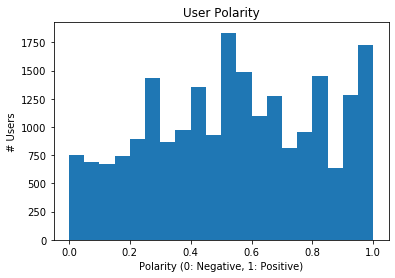

In [19]:
plt.hist(polarities, bins=20)
plt.title('User Polarity')
plt.xlabel('Polarity (0: Negative, 1: Positive)')
plt.ylabel('# Users')


No clear evidence of users tending to be always positive or always negative

In [17]:
df_processed = df_processed[['text', 'target']]

### Text data processing (some parts should be considered improvements and should go after Baseline)

Emoji Processing
- It seems like most emojis are already stripped from the text

In [18]:
# check if tweets contain emojis
df_processed.text.str.contains(':D').sum()

1

In [19]:
df_processed[df_full.text.str.contains(':D')]

,text,target
836189,::::::::::::::DDDDDDDDDDDDDDD WOHO IM SUPE...,1


In [20]:
df_processed.text.str.contains(':\(').sum()

6

In [21]:
df_processed[df_full.text.str.contains(':\(')]

,text,target
295762,@stephanna49 lol noo mr. berst didnt read us t...,0
300429,I wish I was going to CineVegas. (:(: ...,0
496591,@joystiq refreshing for the pas thalf hour my...,0
512042,"@Flombie YES YOU MUST :::::(((( lmao, you g...",0
616016,@macsbabygurl Sorry I probably cant come over....,0
1589469,Mornin' Twit Fam! :::::REMINDER:::((((GOD LOVE...,1


Text Processing

In [22]:
# Change all text to lower case
df_processed['text'] = df_processed['text'].apply(lambda x: x.lower())
df_processed['text']

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          is upset that he can't update his facebook by ...
2          @kenichan i dived many times for the ball. man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 1600000, dtype: object

User Handle Processing

In [23]:
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
USERNAME_TOKEN = "USERNAME"
# Replace any @username with USERNAME token
df_processed['text'] = df_processed['text'].apply(lambda x: re.sub(user_mention, USERNAME_TOKEN, x))
df_processed['text']

0          USERNAME http://twitpic.com/2y1zl - awww, that...
1          is upset that he can't update his facebook by ...
2          USERNAME i dived many times for the ball. mana...
3            my whole body feels itchy and like its on fire 
4          USERNAME no, it's not behaving at all. i'm mad...
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday USERNAME USERNAME USERNAME 
Name: text, Length: 1600000, dtype: object

URL Processing

In [24]:
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
URL_TOKEN = "URL"
df_processed['text'] = df_processed['text'].apply(lambda x: re.sub(url, URL_TOKEN, x))
df_processed['text']

0          USERNAME URL - awww, that's a bummer.  you sho...
1          is upset that he can't update his facebook by ...
2          USERNAME i dived many times for the ball. mana...
3            my whole body feels itchy and like its on fire 
4          USERNAME no, it's not behaving at all. i'm mad...
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday USERNAME USERNAME USERNAME 
Name: text, Length: 1600000, dtype: object

Hashtag Processing

In [25]:
# replace #hashtag with hashtag
df_processed['text'] = df_processed['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', x))
df_processed['text']

0          USERNAME URL - awww, that's a bummer.  you sho...
1          is upset that he can't update his facebook by ...
2          USERNAME i dived many times for the ball. mana...
3            my whole body feels itchy and like its on fire 
4          USERNAME no, it's not behaving at all. i'm mad...
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy  charitytuesday  USERNAME USERNAME USERN...
Name: text, Length: 1600000, dtype: object

IDEA: hashtag tends to combine words together, like "charitytuesday" - maybe find a way to split hashtag words? 

Emoji Processing

In [26]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# replace emojis with words

for emoji, word in emojis.items():
    df_processed['text'] = df_processed['text'].str.replace(re.escape(emoji),re.escape(word))

Other Processing

In [27]:
# remove repeated chars
df_processed['text'] = df_processed['text'].apply(lambda x: re.sub('([a-zA-Z])\\1+', '\\1\\1', x))
df_processed['text']

0          USERNAME URL - aww, that's a bummer.  you shou...
1          is upset that he can't update his facebook by ...
2          USERNAME i dived many times for the ball. mana...
3            my whole body feels itchy and like its on fire 
4          USERNAME no, it's not behaving at all. i'm mad...
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of all time!!! t...
1599999    happy  charitytuesday  USERNAME USERNAME USERN...
Name: text, Length: 1600000, dtype: object

In [28]:
# remove numbers? new_row = re.sub(number, '', new_row)
# remove repeated chars? new_row = re.sub('([a-zA-Z])\\1+', '\\1\\1', new_row)
# deal with any of remaining emojis if any?

### Train Test Split

In [29]:
from sklearn.model_selection import train_test_split

x = df_processed.text
y = df_processed.target

SEED = 2000

#split clean data to two sets: training, validation and test
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.1, random_state=SEED)
#split the second set into two other sets : validation , test 
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))

print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))

print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))


Train set has total 1440000 entries with 49.97% negative, 50.03% positive
Validation set has total 80000 entries with 50.27% negative, 49.73% positive
Test set has total 80000 entries with 50.18% negative, 49.82% positive


Write to CSVs

In [30]:
pd.DataFrame({'text': x_train, 'target': y_train}).to_csv('data/training.1440000.csv', index=False)
pd.DataFrame({'text': x_validation, 'target': y_validation}).to_csv('data/validation.80000.csv', index=False)
pd.DataFrame({'text': x_test, 'target': y_test}).to_csv('data/test.80000.csv', index=False)